In [1]:
import csv
import polars as pl
import yfinance as yf
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
class Data_Engineering():
    def __init__(self, year):
        self.year = year
        self.value_asset_data = dict()
        self.price_data = dict()
        self.amount_data = dict()

    @staticmethod
    def to_polars(dictionary):
        """
        To convert dictionaries into polars dataframe
        """
        return pl.DataFrame(dictionary) 
    
    @staticmethod
    def _concatenate_dicts(dict1, dict2):
        """
        Hidden function which concatenates two dictionaries based on common keys, values for each key are already sorted

        Args:
        - dict1 (dict): First dictionary.
        - dict2 (dict): Second dictionary.

        Returns:
        - concatenated_dict (dict): A new dictionary with concatenated lists for matching keys.
        """

        concatenated_dict = {}
        keys = set(dict1.keys()) & set(dict2.keys()) # find the intersection of keys
        for key in keys: # for each commons keys, concatenate their values
            concatenated_dict[key] = dict1[key] + dict2[key]
        return concatenated_dict

    def value_asset_data_retriever(self, asset_line_end, asset_line_start=3, to_polars=False):
        """
        Retrieve data from a file stored in the source_files folder, whose name is in the format "YYYY.csv". Lines contains monthly value for each asset in rows, calculated at the end of each month.
        
        Args:
            asset_line_end (int): what's the last line corresponding to an asset
            asset_line_start (int, default = 3): what's the first line corresponding to an asset
            to_polars (bool, default = False): convert to polar

        """
        with open('source_files/' + str(self.year) + '.csv', mode='r') as f:
            reader = csv.reader(f)
            # Skip the first 3 lines
            for _ in range(asset_line_start):
                next(reader)

            # create a dictionary whose keys are tickers and values are the list of values in dollars for each asset, for each month
            for i, values in enumerate(reader):
                if i == asset_line_end - asset_line_start:
                    break
                self.value_asset_data[values[0]] = list(map(lambda x: int(x.replace(',', '')), values[3:15]))

        if to_polars:
            self.value_asset_data = self.to_polars(self.value_asset_data)

    def price_data_retriever(self, sampling = 'ME', to_polars=False):
        """
        Retrieve closing price data from yahoo finance for each ticker, in the given year
        
        Args:
            sampling (string, default = 'ME'): what's the frequency of data? 'ME' for monthly data
            to_polars (bool, default = False): convert to polar

        """
        tickers = list(self.value_asset_data.keys())
        for ticker in tickers:
            if ticker == "INTEL":   # to be deleted
                continue            # to be deleted
            self.price_data[ticker] = yf.Ticker(ticker).history(start = str(self.year) + '-01-01', 
                                                                end=str(self.year + 1) + '-01-01')['Close']
            if sampling == 'ME':
                self.price_data[ticker] = self.price_data[ticker].resample('ME').last().tolist()
                
        if to_polars:
            self.price_data = self.to_polars(self.price_data)

    def amount_data_calculator(self, to_polars=False):
        """
        Calculate the amount of asset each month, per each ticker
        """

        for key in self.value_asset_data:
            if key == "INTEL":      # to be deleted
                continue            # to be deleted
            self.amount_data[key] = [value / price for value, price in zip(self.value_asset_data[key], self.price_data[key])]

        if to_polars:
            self.amount_data = self.to_polars(self.amount_data)

    def get_difference(self, mode, diff=1, pct_change=False):
        """
        Calculate absolute or percentuale change in price or amount of asset per each moment
        
        Args:
            mode (string): "price" or "amount", according to the data to calculate the difference of
            diff (int, default = 1): lag
            pct_change (bool, default = False): calculate the percentuale change
        
        Returns:
            pl.Dataframe (polar dataframe)
        """
        if mode == "price":
            data = self.price_data if isinstance(self.price_data, pl.DataFrame) else self.to_polars(self.price_data)
            if pct_change:
                self.price_difference_pct = data.select(pl.all().pct_change(diff))
                return self.price_difference_pct
            else:
                self.price_difference = data.select(pl.all().diff(diff))
                return self.price_difference

        elif mode == "amount":
            data = self.amount_data if isinstance(self.amount_data, pl.DataFrame) else self.to_polars(self.amount_data)
            self.difference_amount = data.select(pl.all().diff(diff))
            return self.difference_amount

    def concatenate_data(self, older):
        """
        Concatenate data from another DataEngineering instance into this one.

        Args:
        - older (InstanceClass): Another instance of DataEngineering to concatenate with.

        Returns:
        - new_instance (InstanceClass): A new instance with concatenated data.
        """
        concatenated_value_asset_data = self._concatenate_dicts(older.value_asset_data, self.value_asset_data)
        concatenated_price_data = self._concatenate_dicts(older.price_data, self.price_data)
        concatenated_amount_data = self._concatenate_dicts(older.amount_data, self.amount_data)
        
        # Create a new instance with default year and updated data
        new_instance = Data_Engineering(year = self.year)
        new_instance.value_asset_data = concatenated_value_asset_data
        new_instance.price_data = concatenated_price_data
        new_instance.amount_data = concatenated_amount_data
        return new_instance

data_2023 = Data_Engineering(2023)
data_2023.value_asset_data_retriever(13)
data_2023.price_data_retriever()
data_2023.amount_data_calculator()

data_2022 = Data_Engineering(2022)
data_2022.value_asset_data_retriever(16)
data_2022.price_data_retriever()
data_2022.amount_data_calculator()

# Concatenate data

data_2022_2023 = data_2023.concatenate_data(data_2022)

# Exploratory Data Analysis

In [3]:
value_dataframe = pd.DataFrame(data_2022_2023.value_asset_data)
plt.style.use('ggplot')

In [4]:
value_dataframe.head()

,VT,INTEL,VYM,CHEK,ERUS,VBR,SONY,VYMI,VSS,VTV
0,174267,24410,50184,9234,0,68384,11166,219808,50476,142765
1,169439,23850,49446,9882,0,69496,10253,215392,49492,142925
2,172193,24780,50513,7800,8060,70376,10271,216384,49556,144890
3,163373,21795,48389,7200,8060,65916,8605,204320,45884,140700
4,164180,22210,50090,7200,8060,67144,9407,208000,46248,144090


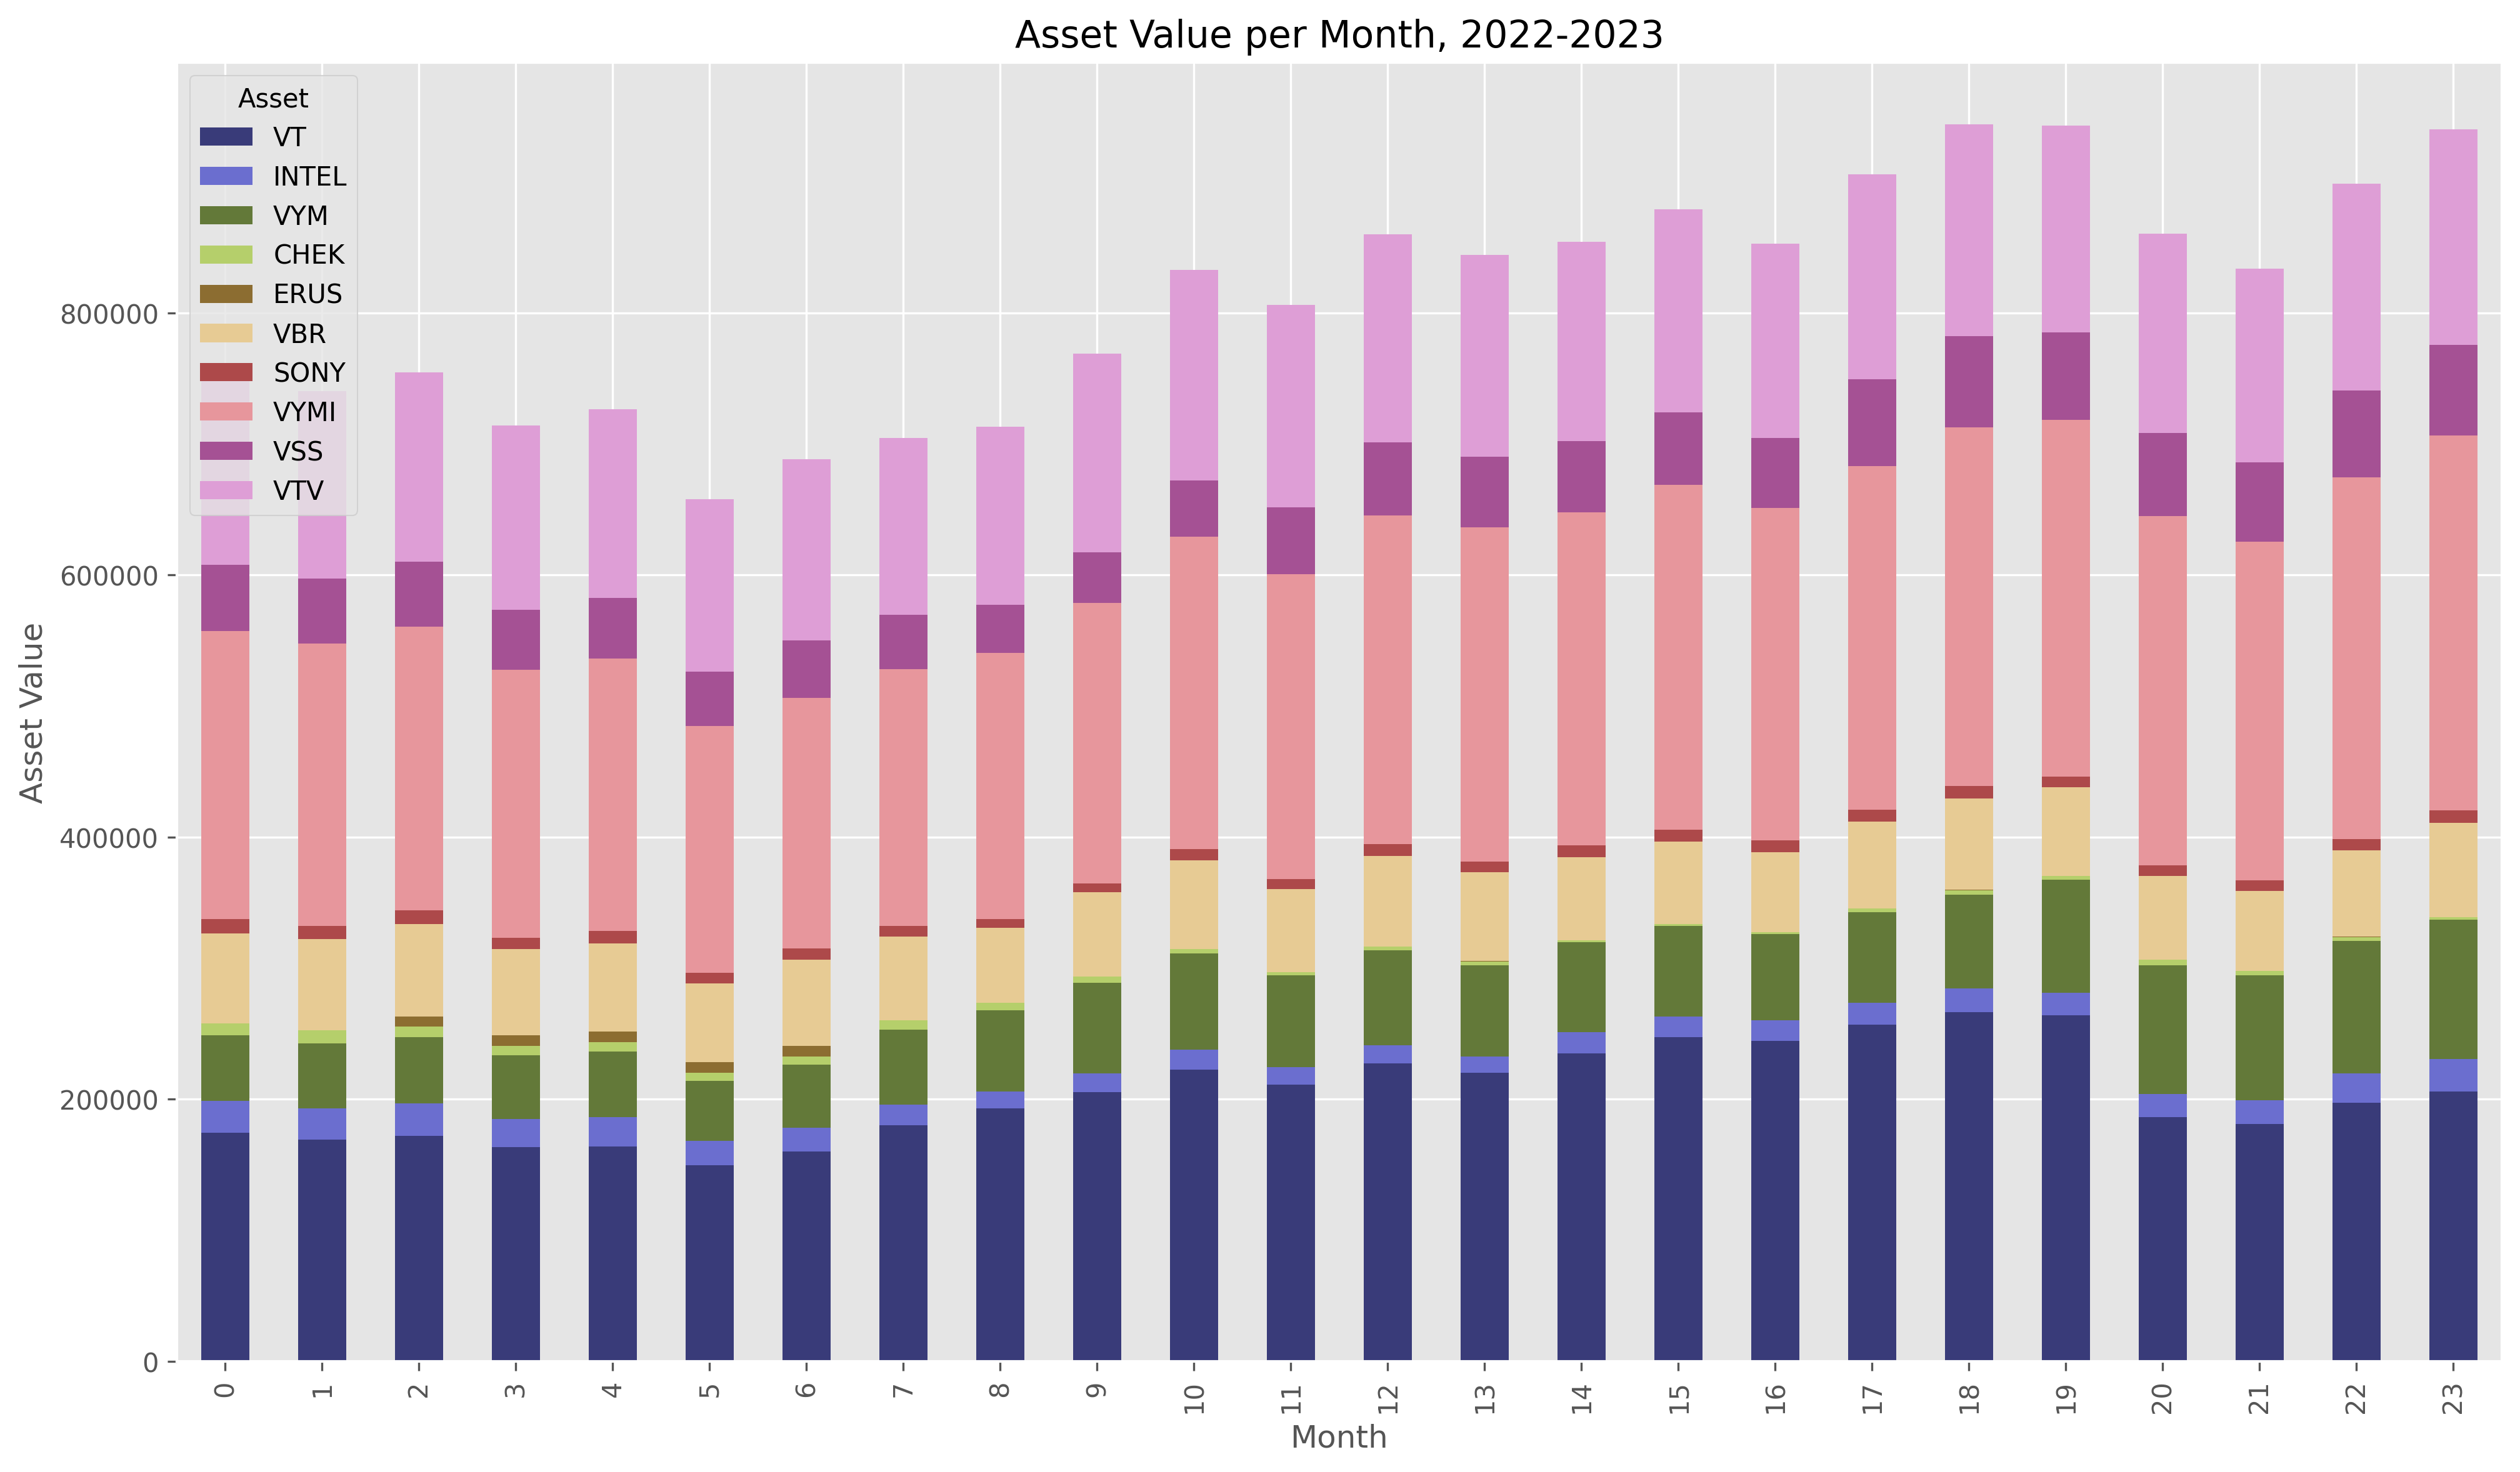

In [5]:
value_dataframe.plot(kind = 'bar', stacked = True, colormap = 'tab20b', figsize=(16,9))
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Asset Value')
plt.title('Asset Value per Month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.show()

In [6]:
amount_data, price_data = data_2022_2023.get_difference("amount"), data_2022_2023.get_difference("price", pct_change = True)

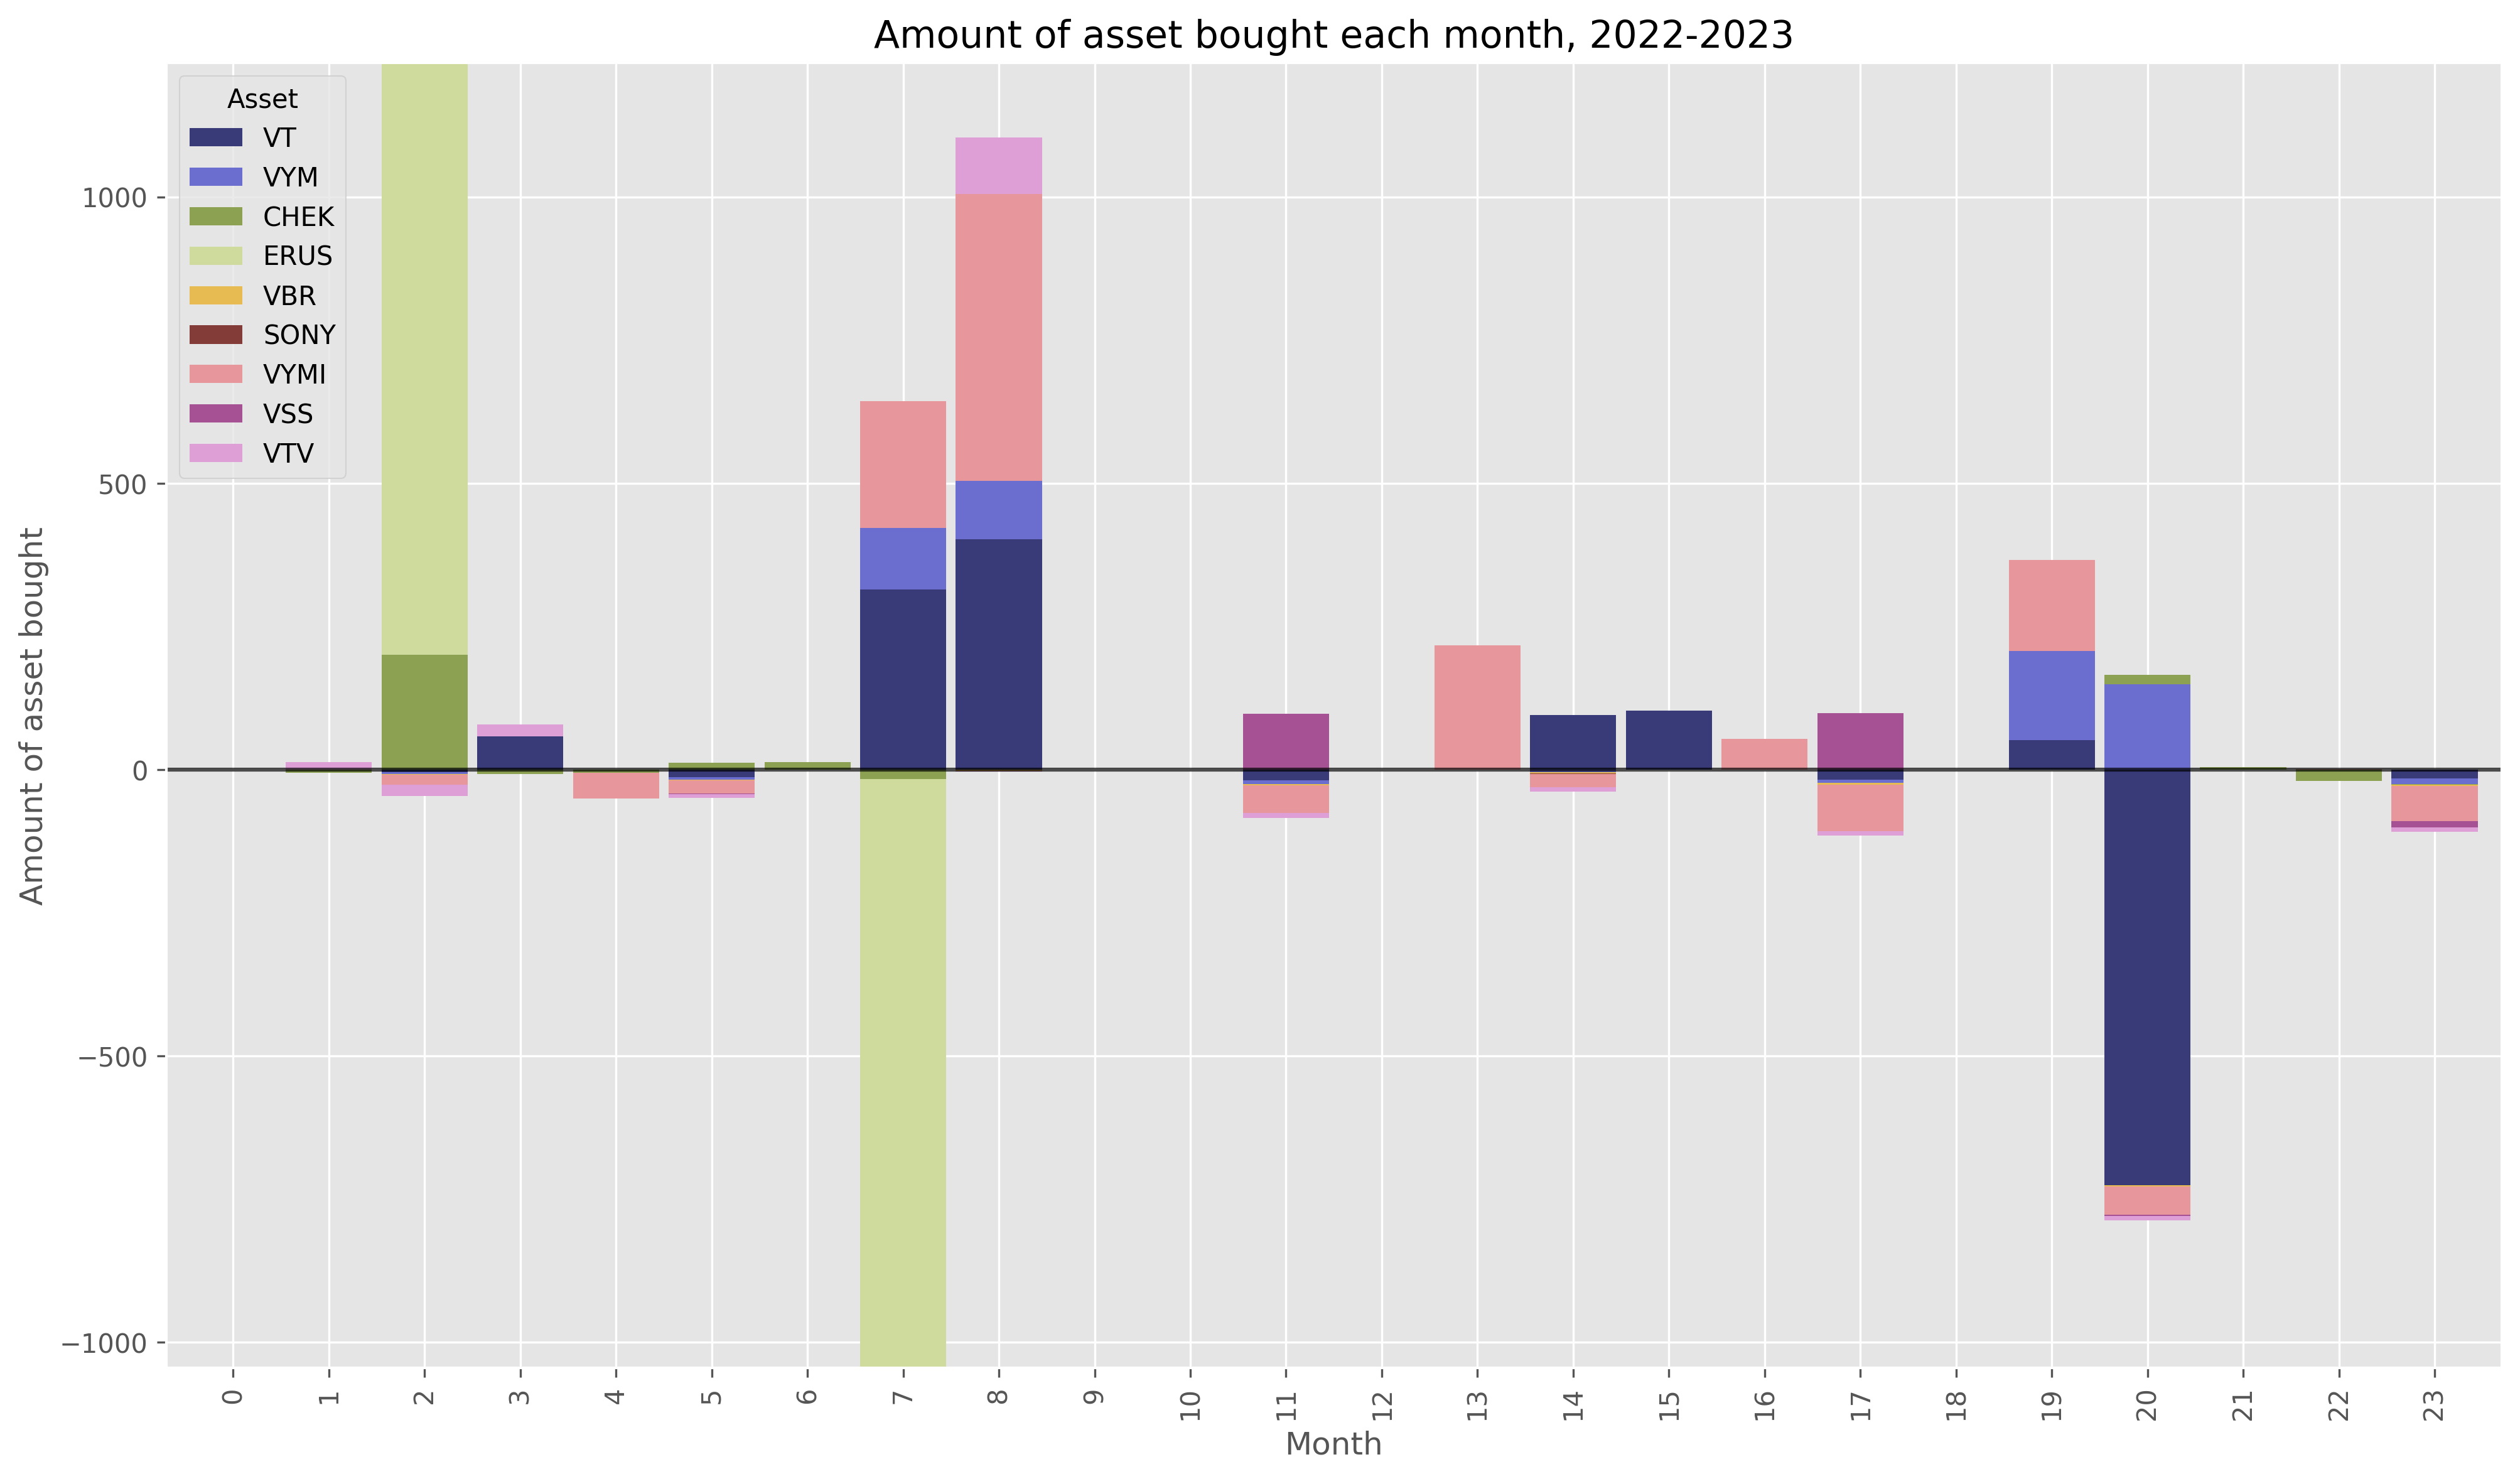

In [7]:
amount_data.to_pandas().plot(kind = 'bar', figsize = (16,9), stacked = True, width = 0.9, colormap = 'tab20b')
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Amount of asset bought')
plt.title('Amount of asset bought each month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.axhline(y = 0, color = 'black', alpha = 0.7)
plt.show()

# Detecting statistically significant correlations in asset purchasing
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,
* their monthly price $Price_{A, t}$

For each asset $A$ is calculated the pearson correlation between its Quantity and Quantities and Prices of any other asset, at different time lags, as well.
The variables significantly correlated will be returned, and their correlation coefficients.

In [8]:
class Correlation:
    """The correlation class provide a series of attributes to manipulate data and get significant correlation coefficients between current and/or past prices and the amount of asset bought at any given time"""
    def __init__(self, list_of_dataframes):
        """
        Args:
            list_of_dataframes (list): a list containg different dataframes, whose columns will be the variables among which the correlation coefficients will be calculated
        """
        self.list_of_dataframes = list_of_dataframes

    def add_shifting(self, list_of_dataframe_index_to_apply_shifting, list_of_lags, add = False):
        """
        Method to add lags - shifting the row up or down by n lags -, and eventually appending the shifted dataframe or substituiting it
        Args: 
            list_of_dataframe_index_to_apply_shifting (list) : a list contaings int, corresponding to the indexes of dataframe you want to apply shifting in self.list_of_dataframess list
            list_of_lags (list) : a list containing positive or negative int, corresponding to the number of lags to be applied for each dataframe 
            add (bool, default = False) : if you want to substitute or append the shifted dataframe

        Example:
            INSTANCE.add_shifting([1],[1], add = True)
            will apply to the the 2nd dataframe of self.list_of_dataframse a shift of +1 and the resulting dataframe will be appended
        """
        for ix, dataframe_index in enumerate(list_of_dataframe_index_to_apply_shifting):
            lag = list_of_lags[ix]
            df = self.list_of_dataframes[dataframe_index]
            shifted_df = df.shift(lag)  

            # Renaming the column according to the lag applied
            new_column_names = {col: f"{col}_{lag}" for col in df.columns}

            shifted_df = shifted_df.rename(new_column_names)

            # Replace the DataFrame in the list or append it if 'add' is True
            if add:
                self.list_of_dataframes.append(shifted_df)
            else:
                self.list_of_dataframes[dataframe_index] = shifted_df

    def combine_dataframes(self, shared_names=False, list_of_suffix=None):
        """
        Method to combine dataframes. In case dataframes have the same name, prompt "True" and a list of suffix, per each dataframe, so that the first suffix will be added to all the columns in the first dataframe
        Args:
            shared_names (bool, default = False) : do the combined dataframe have at least one common column name?
            list_of_suffix (list, default = None) : if shared_names == True, provide a list of strings for suffixes, one per each dataframe yo're going to combine. An empty string can be used if only a part of the dataframes share column names
        """
        if shared_names:
            if list_of_suffix is None:
                raise ValueError("list_of_suffix must be provided when shared_names is True")
            
            # Add suffixes to each DataFrame's columns
            for index, df in enumerate(self.list_of_dataframes):
                suffix = list_of_suffix[index]
                self.list_of_dataframes[index] = df.rename(
                    {col: f"{col}{suffix}" for col in df.columns}
                )
        
        self.combined_dataframes = pl.concat(self.list_of_dataframes, how="horizontal").drop_nulls()

    def calculate_correlation(self):
        """
        Calculate correlations among each pair of columns and display only the significant ones
        """

        columns = self.combined_dataframes.columns
        
        self.correlations = {}
        
        for column_a in columns:
            for column_b in columns:
                # Don't calculate correlation of a column with itself and skip the calculations with prices
                if column_a == column_b or column_a.endswith("p"):
                    continue
                else:
                    corr, p_value = pearsonr(self.combined_dataframes[column_a], self.combined_dataframes[column_b])
                    if p_value <= 0.05:
                        if f"{column_b} vs. {column_a}" not in self.correlations:
                            self.correlations[f"{column_a} vs. {column_b}"] = float(corr)
    
correlation = Correlation([amount_data, price_data])
correlation.add_shifting([1],[3], add = True)
correlation.combine_dataframes(shared_names=True, list_of_suffix=['a','p','p'])
correlation.calculate_correlation()
correlation.correlations

{'VTa vs. CHEKa': -0.5322858001079533,
 'VTa vs. VYMIa': 0.5719412157579526,
 'VTa vs. VTVa': 0.4931882893302626,
 'VTa vs. CHEK_3p': -0.5378385245065868,
 'VYMa vs. SONYa': -0.46406236219722696,
 'VYMa vs. VYMIa': 0.5186672670185102,
 'VYMa vs. VTp': -0.499556090959909,
 'VYMa vs. SONYp': -0.47089187208213157,
 'VYMa vs. VSSp': -0.4738075010434728,
 'CHEKa vs. ERUSa': 0.4707465506140153,
 'CHEKa vs. ERUSp': -0.4707465506140152,
 'ERUSa vs. ERUSp': -1.0,
 'VBRa vs. SONYa': 0.5196558530733845,
 'VBRa vs. VSSa': -0.4642540979806095,
 'VBRa vs. VBR_3p': 0.448283928236228,
 'SONYa vs. VTVa': -0.5541289741315129,
 'SONYa vs. VBRp': 0.468847109624417,
 'VYMIa vs. VTVa': 0.8267648723262307,
 'VYMIa vs. VTp': -0.5318438054532187,
 'VYMIa vs. VYMp': -0.48868357826082803,
 'VYMIa vs. SONYp': -0.5614680206206669,
 'VYMIa vs. VYMIp': -0.5481262257725164,
 'VYMIa vs. VSSp': -0.5190982960579048,
 'VYMIa vs. VTVp': -0.4951055516478623}

# Detecting purchasing strategy: focusing on the amount bought each month of the same asset using a time-series approach
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,

For each asset $A$, using time-series analysis, discovering any statistically significant association between $Quantity_{A, t}$ at any given time and $Quantity_{A, t-n}$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

Interestingly enough, the couples
* VT - VYM
* CHECK - ERUS
* VBR - SONY
* VYMI - VSS 
show some visual similarities. However, correlation among different asset will be assessed in a different section

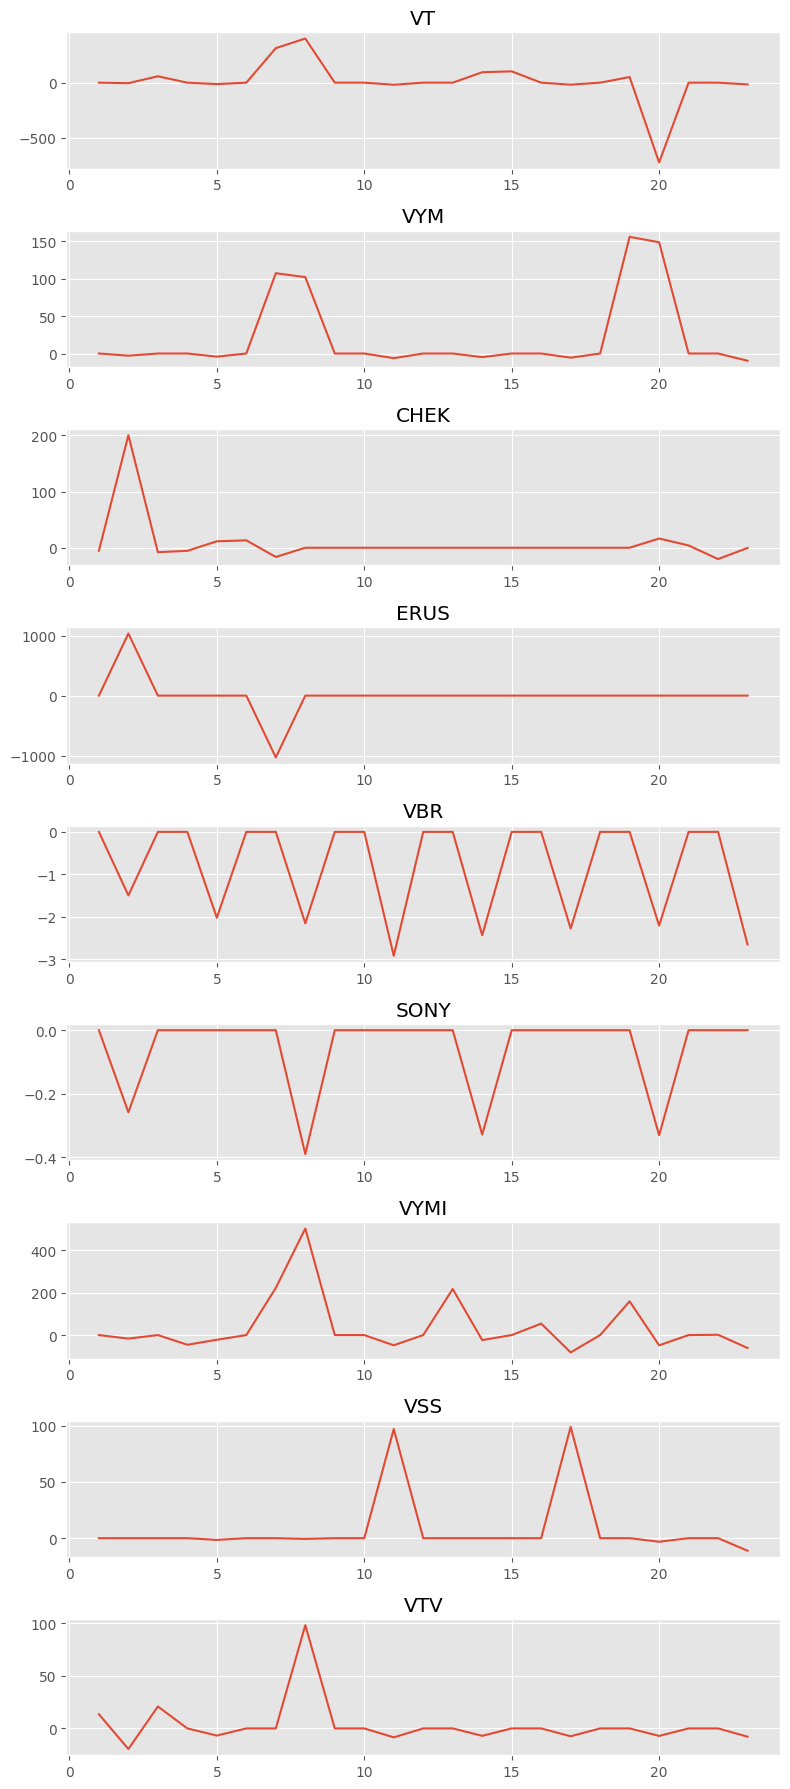

In [10]:
amount_data = amount_data.to_pandas().dropna()

num_columns = len(amount_data.columns)
fig, axs = plt.subplots(num_columns, 1, figsize=(8, 2 * num_columns))

# Plot each column in a separate subplot
for i, column in enumerate(amount_data.columns):
    axs[i].plot(amount_data.index, amount_data[column])
    axs[i].set_title(f'{column}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Calculating the stationarity using KPSS and ADF tests.

In [11]:
def adf_test(dataframe):
    """
        Calculating stationarity on each dataframe column using KPSS and ADF tests.
        Args:
            dataframe (pandas.Dataframe) : dataframe whose columns are time series and stationarity should be calculated
        """
    for column in dataframe.columns:
        adf_test = adfuller(dataframe[column], autolag="AIC")
        kpss_test = kpss(dataframe[column], regression="c", nlags="auto")
        print("Stationarity check for", column)
        if adf_test[1] < 0.05:
            print("The series is stationary based on ADF test")
        else: 
            print("The series is not stationary based on ADF test")
        if float(kpss_test[1]) < 0.05:
            print("The series is not stationary based on KPSS test")
        else:
            print("The series is stationary based on KPSS test\n")
    
adf_test(amount_data)

Stationarity check for VT
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYM
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for CHEK
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for ERUS
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VBR
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for SONY
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYMI
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VSS
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VTV
The series is not stationary based on ADF 

/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Plotting Time Series, ACF and PACF

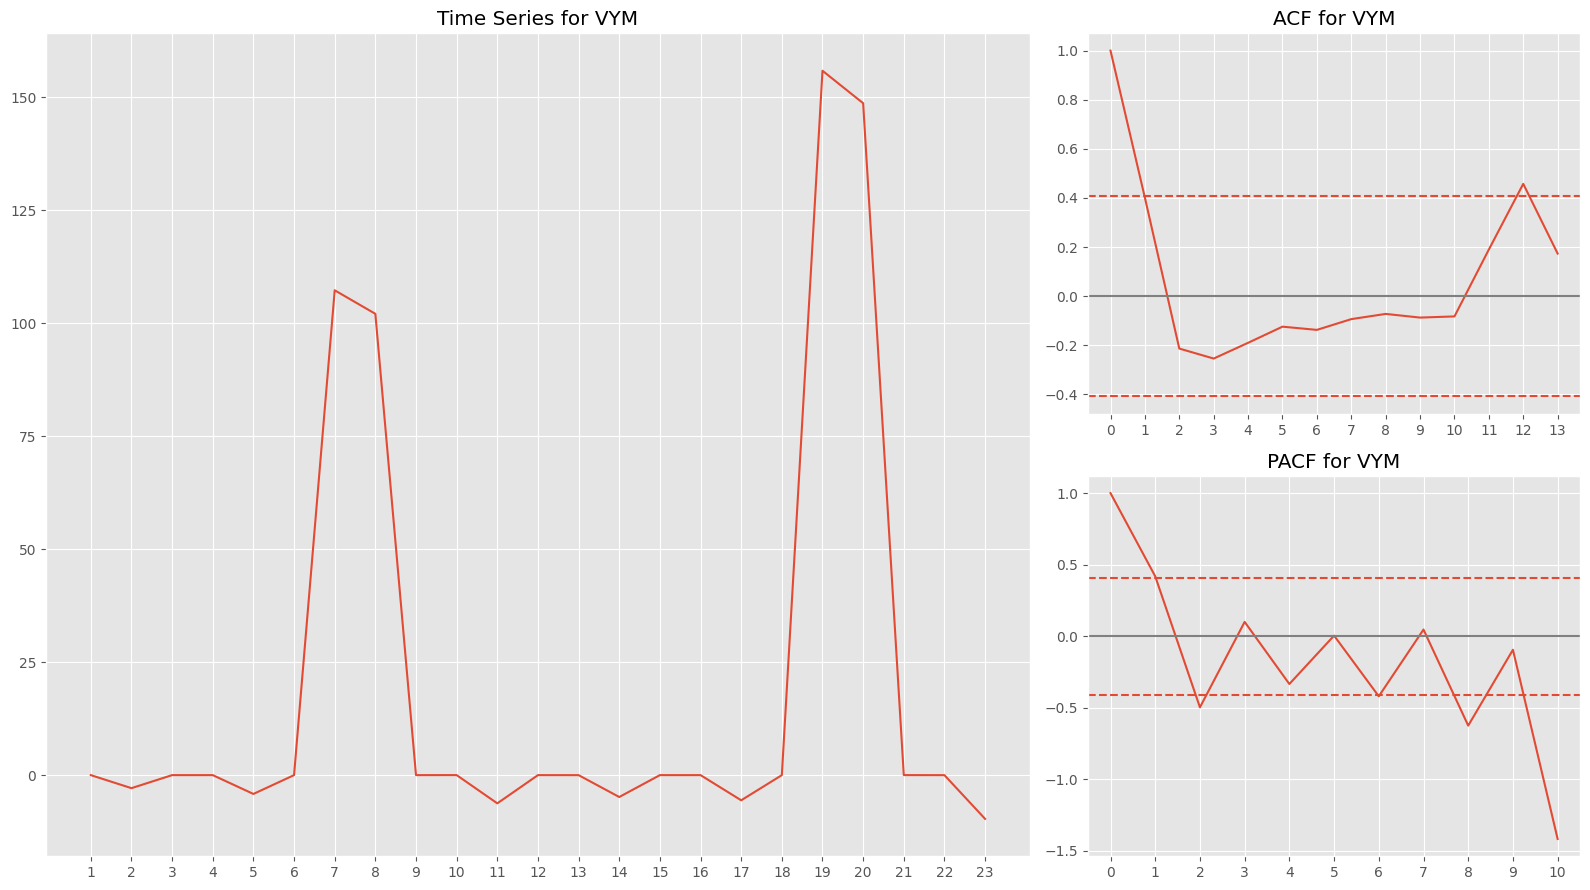

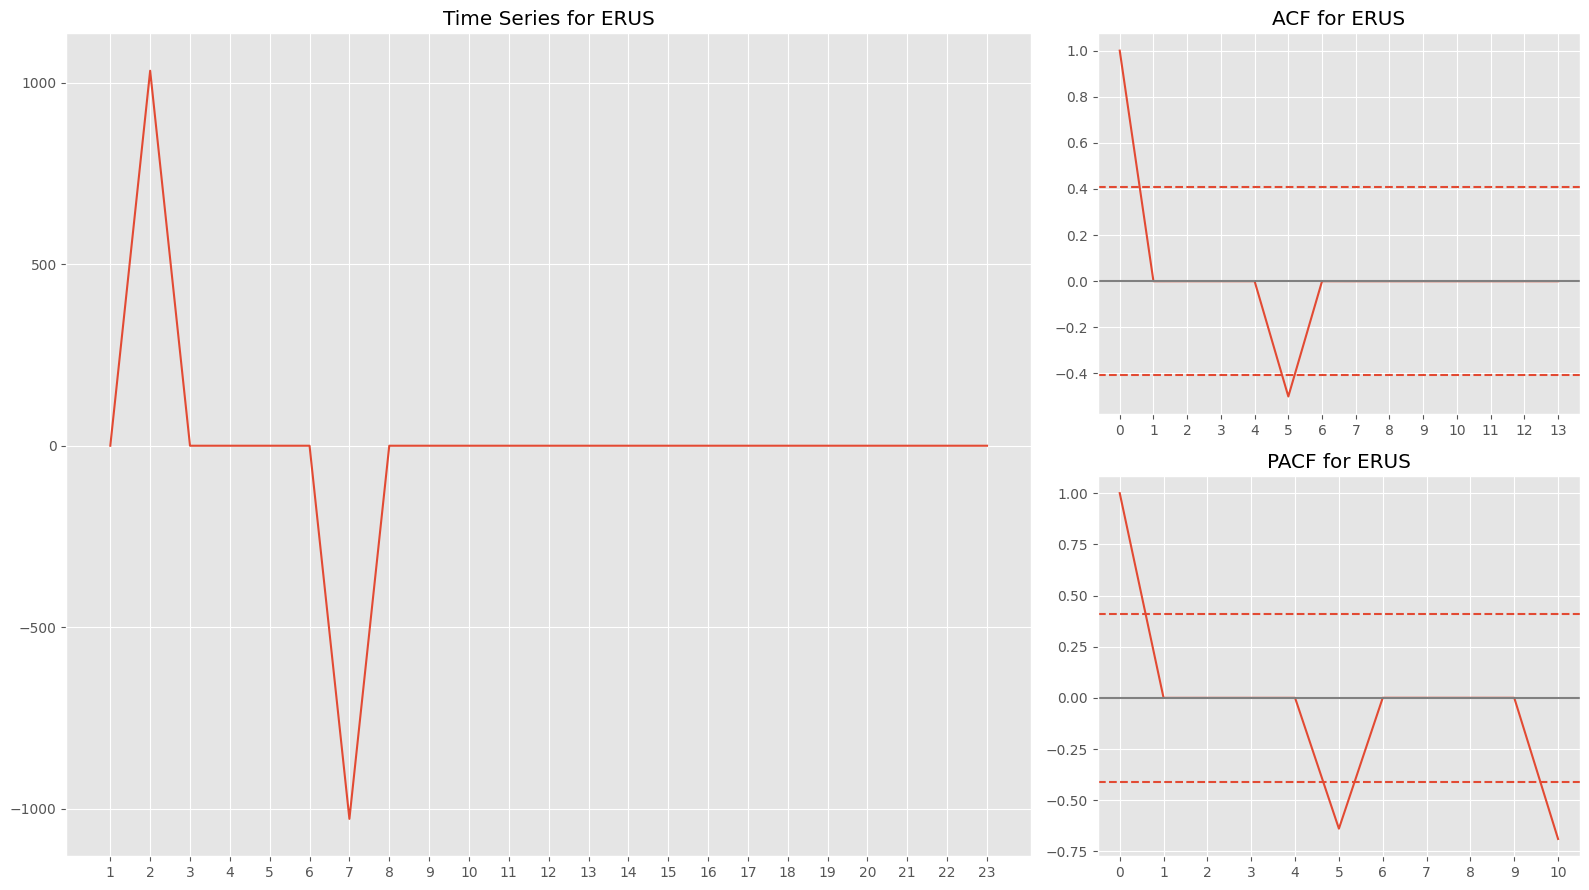

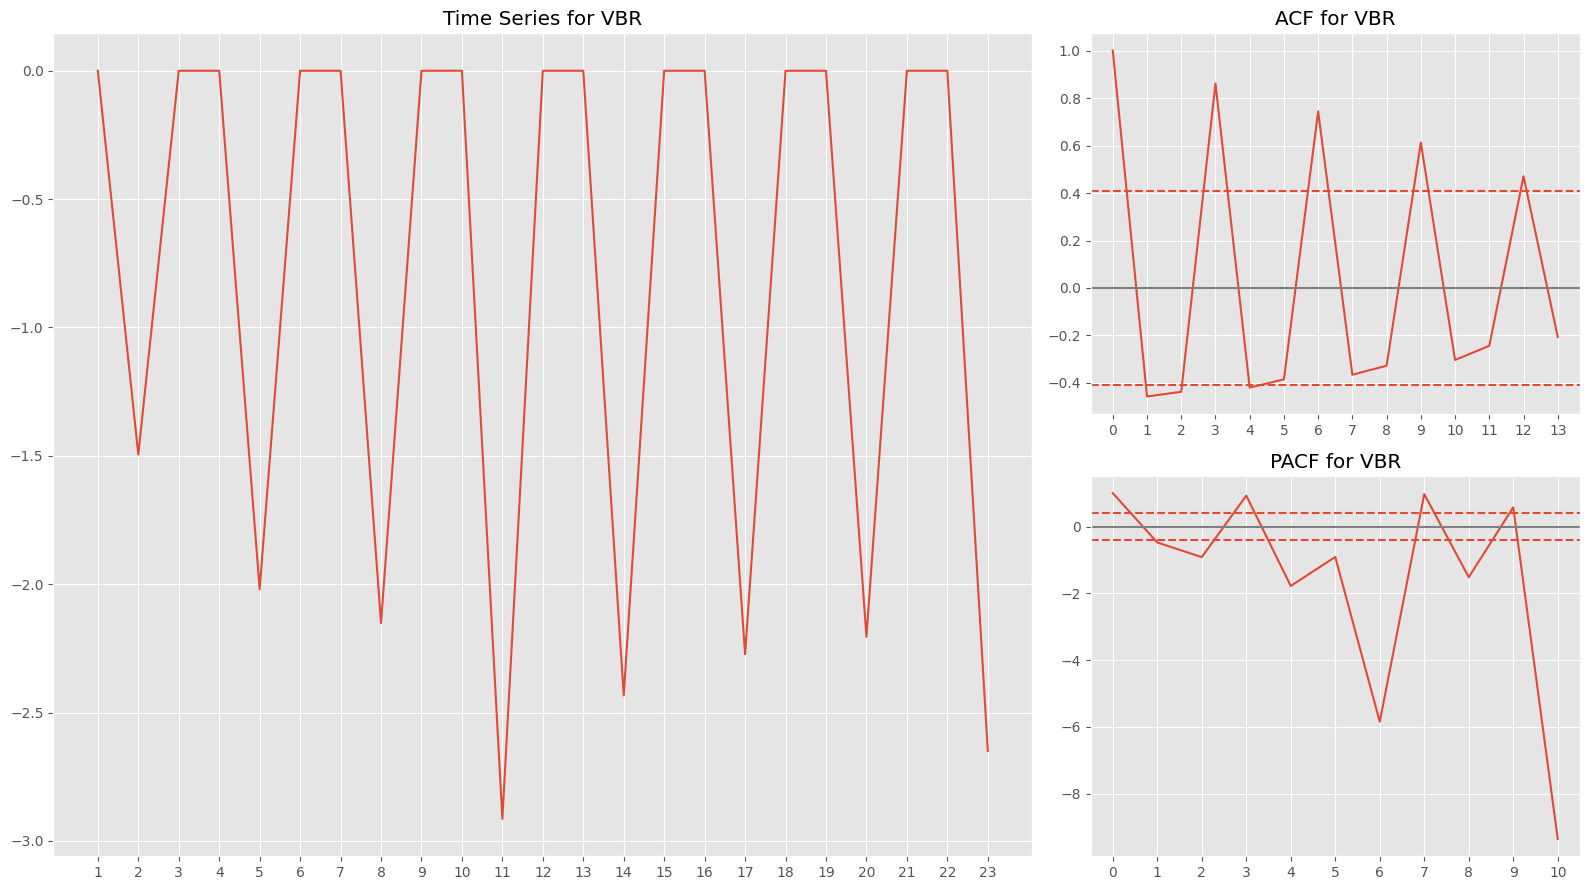

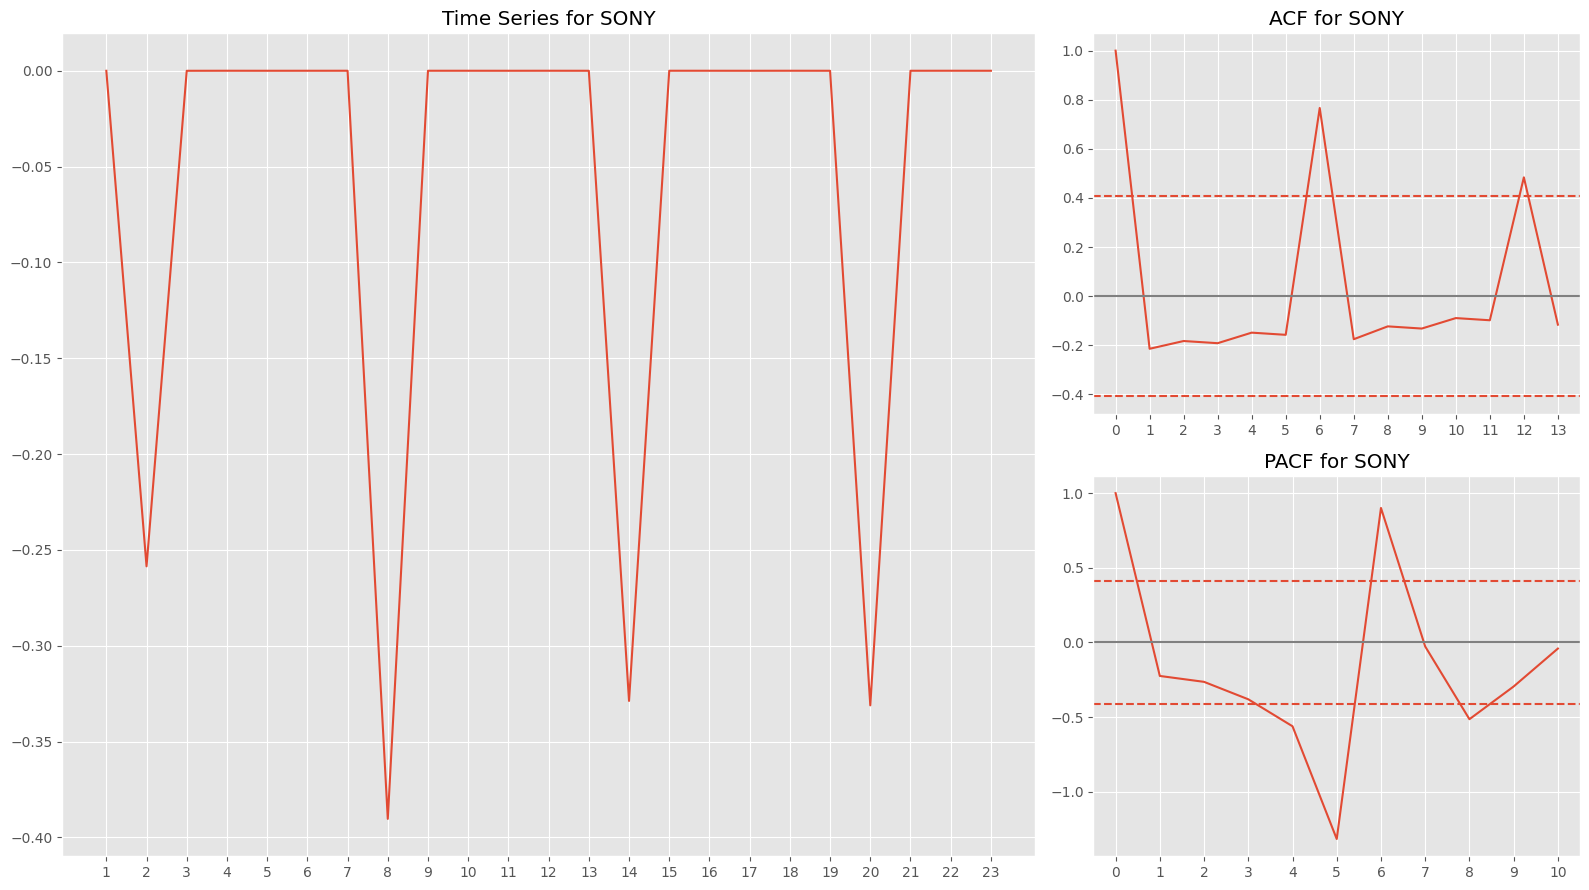

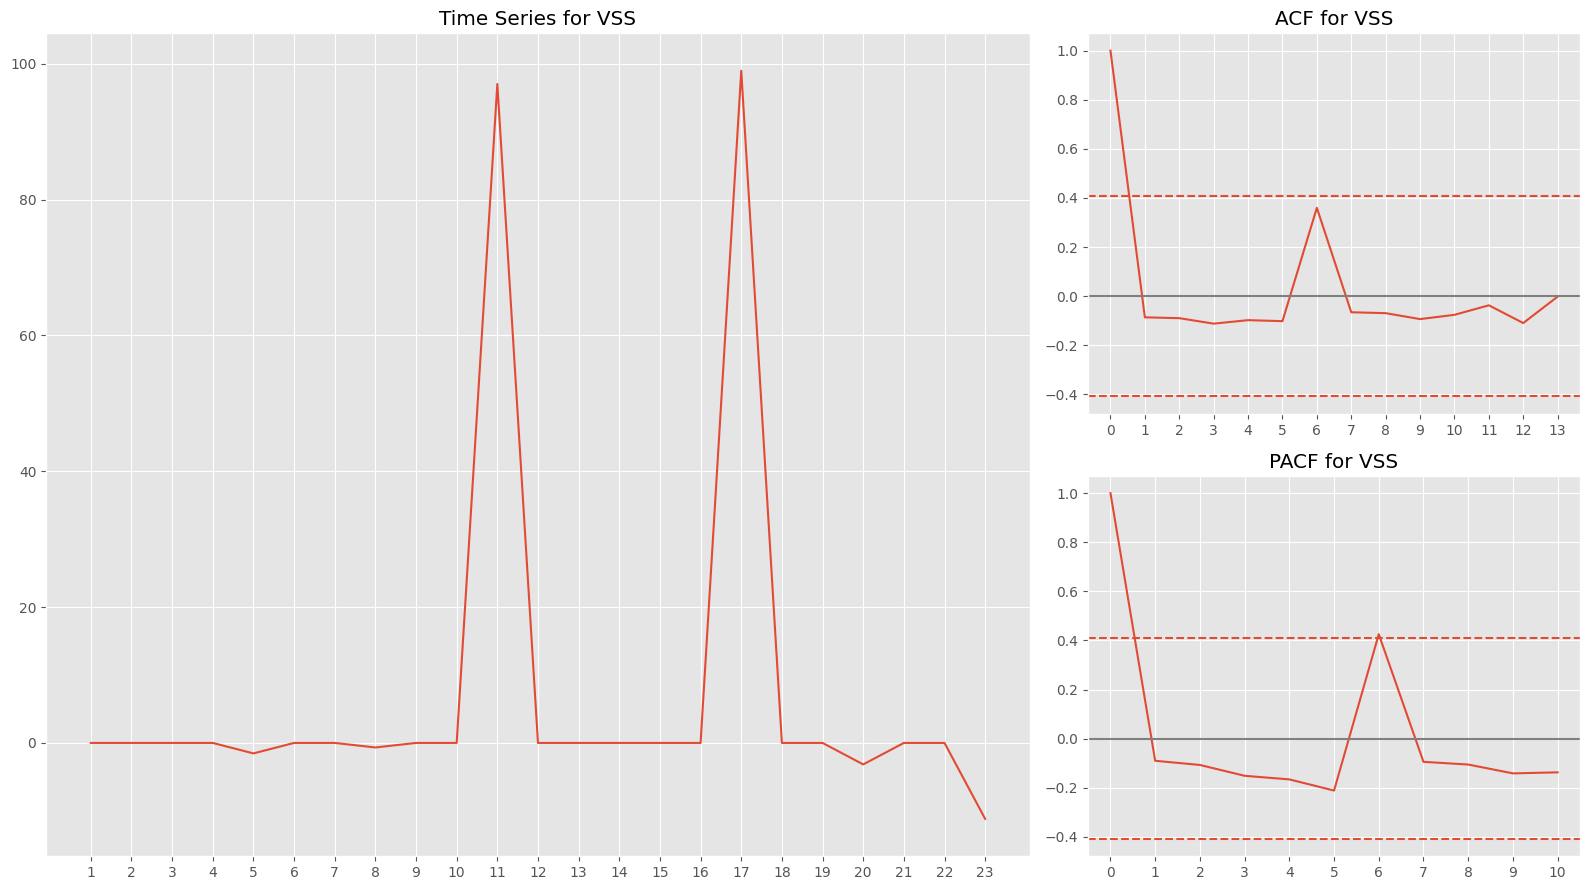

In [20]:
def plotting(function):
    x_values = np.arange(0, len(function))
    plt.plot(x_values, function)
    plt.axhline(0, color='grey')
    plt.axhline(confidence_interval, linestyle='dashed')
    plt.axhline(-confidence_interval, linestyle='dashed')
    plt.xticks(x_values)

for column in amount_data.columns:
    # For each amount of asset bought and sold, calculate the auto correlation and partial autocorrelation functions
    acf_values = acf(amount_data[column])
    pacf_values = pacf(amount_data[column])

    # Define a confidence interval
    confidence_interval = 1.96 / np.sqrt(len(amount_data[column]))
    
    # If any of ACF-PACF value exceed the confidence interval excluding the first one - which is always statistically significant - , display the time series, the ACF and PACF
    if any(np.abs(acf_values[1:]) > confidence_interval) or any(np.abs(pacf_values[1:]) > confidence_interval):
        
        fig = plt.figure(figsize=(16, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])

        # Time series plot spanning two rows
        ax0 = fig.add_subplot(gs[:, 0]) 
        ax0.plot(amount_data[column])
        ax0.set_title(f"Time Series for {column}")
        x_values_original = np.arange(1, len(amount_data[column]) + 1)
        ax0.set_xticks(x_values_original)

        # ACF plot
        ax1 = fig.add_subplot(gs[0, 1])
        plt.sca(ax1)
        plotting(acf_values)
        plt.title(f"ACF for {column}")

        # PACF plot
        ax2 = fig.add_subplot(gs[1, 1])
        plt.sca(ax2)
        plotting(pacf_values)
        plt.title(f"PACF for {column}")

        plt.tight_layout()
        plt.show()

Time lags where ACF or PACF exceeds confidence intervals will be the starting point for parameters selection MA and AR models, respectively.
At time lag 0, ACF and PACF always indicate strong association between any given time lag, and itself. Given that, ACF and PACF at time lag 0 will not be considered.

### Testing, fourier and SARIMA

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from scipy.fft import fft, fftfreq

<Axes: >

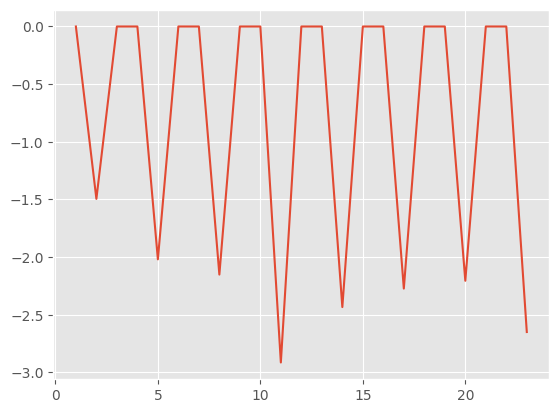

In [67]:
data = amount_data["VBR"]
data.plot()

In [80]:
data

1    -0.000005
2    -1.494895
3     0.000028
4    -0.000029
5    -2.019398
6     0.000128
7    -0.000129
8    -2.151471
9    -0.000045
10    0.000012
11   -2.913871
12   -0.000091
13   -0.000036
14   -2.433334
15   -0.000081
16   -0.000004
17   -2.272892
18    0.000031
19   -0.000041
20   -2.205292
21    0.000083
22   -0.000014
23   -2.649706
Name: VBR, dtype: float64

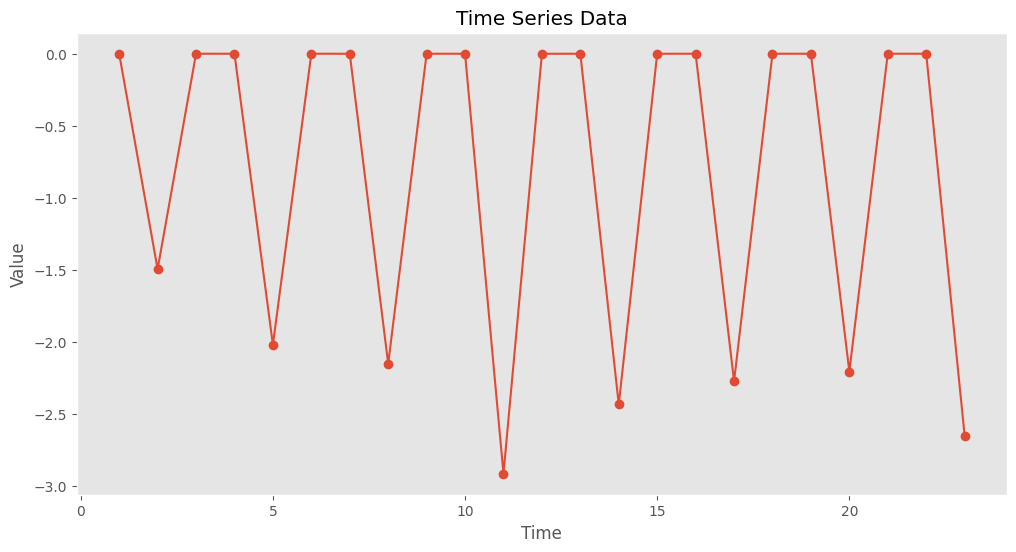

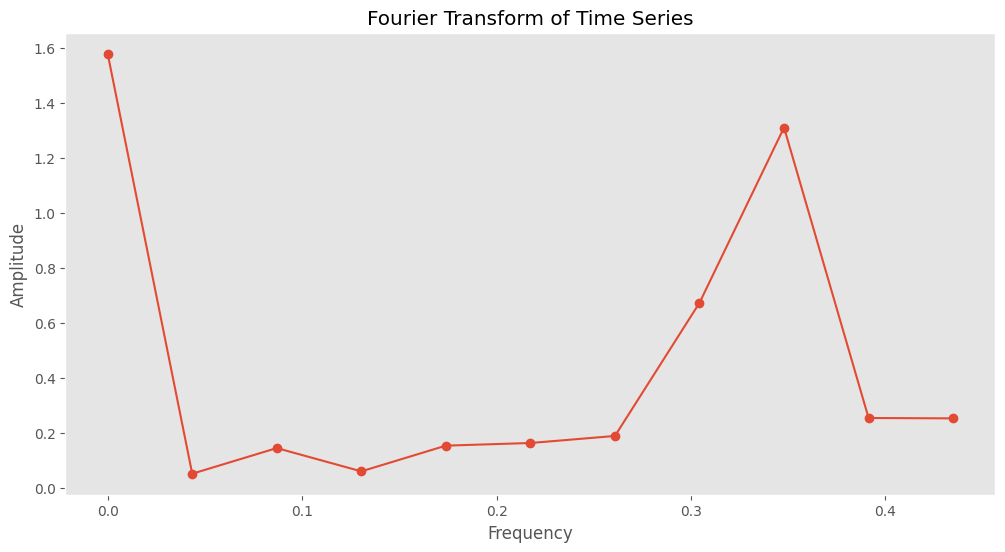

In [82]:
data = {
    'time': np.arange(1, 24),
    'value': [
        -0.000005, -1.494895, 0.000028, -0.000029, -2.019398,
        0.000128, -0.000129, -2.151471, -0.000045, 0.000012,
        -2.913871, -0.000091, -0.000036, -2.433334, -0.000081,
        -0.000004, -2.272892, 0.000031, -0.000041, -2.205292,
        0.000083, -0.000014, -2.649706
    ]
}

df = pd.DataFrame(data)

plt.plot(df['time'], df['value'])
plt.title('Time Series Data')
plt.grid()
plt.show()


n = len(df['value'])
yf = fft(df['value'])
xf = fftfreq(n, 1)[:n//2]  # Only positive frequencies


plt.plot(xf, 2.0/n * np.abs(yf[:n//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

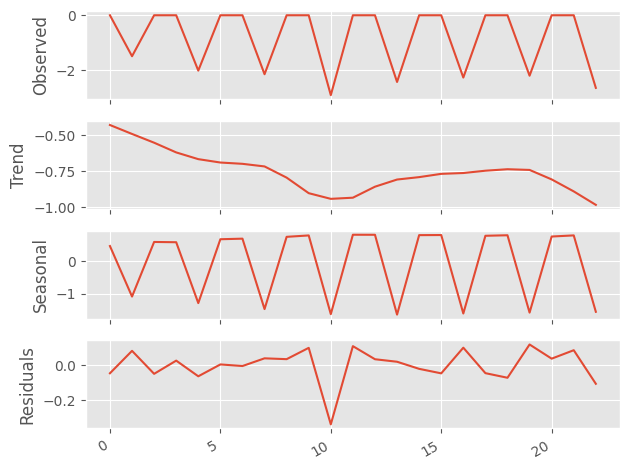

In [84]:
# Decomposition

advanced_decomposition = STL(data['Value'], period = 3).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [79]:
ARIMA_model = auto_arima(amount_data['VBR'], error_action='ignore', trace=True, suppress_warnings=True, seasonal=True, m = 4)
ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=24.627, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=94.127, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=87.467, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=92.217, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=22.996, Time=2.06 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=21.013, Time=0.60 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=23.644, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=19.029, Time=0.14 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=21.008, Time=0.18 sec
 ARIMA(2,1,1)(0,0,1)[4] intercept   : AIC=21.007, Time=0.32 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   : AIC=23.007, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  -5.054
Date:                Tue, 08 Oct 2024   AIC                             18.108
Time:                        16:24:35   BIC                             22.472
Sample:                             0   HQIC                            19.136
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9929      0.510     -1.948      0.051      -1.992       0.006
ar.L2         -0.9860      0.042    -23.317      0.000      -1.069      -0.903
ma.L1          0.0034      3.085      0.001      0.999      -6.043       6.050
sigma2         0.0661      0.016      4.147      0.000       0.035       0.097
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                10.36
Prob(Q):                              0.73   Prob(JB):                         0.01
Heteroskedasticity (H):               0.63   Skew:                            -1.31
Prob(H) (two-sided):                  0.56   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

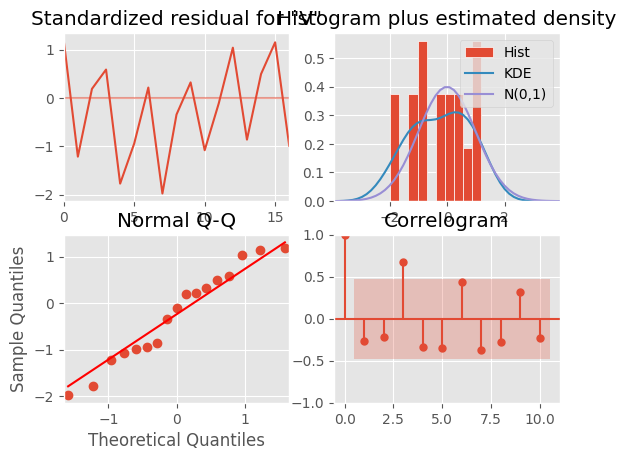

In [32]:
results.plot_diagnostics();
residuals = results.resid

In [33]:
acorr_ljungbox(residuals, np.arange(1, 2, 1))

,lb_stat,lb_pvalue
1,2.786434,0.095066


/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoreg

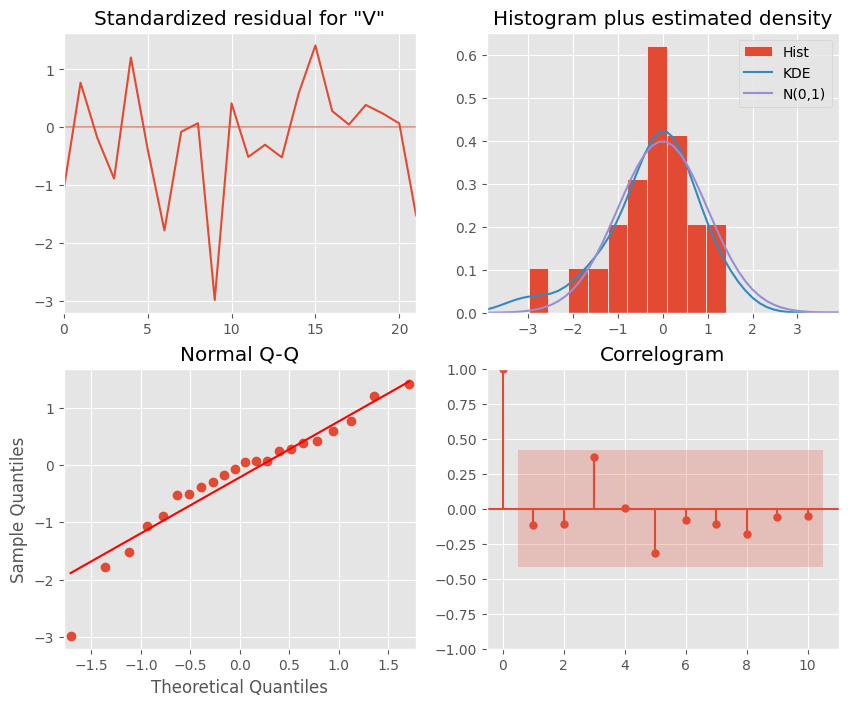

In [49]:
SARIMA_model = SARIMAX(amount_data["VBR"], order=(1,1,1), seasonal_order=(2,0,1,2))
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [50]:
residuals = SARIMA_model_fit.resid

In [51]:
residuals

1    -0.000005
2    -1.494890
3     1.013928
4    -0.182857
5    -0.850352
6     0.527413
7    -0.115258
8    -0.538436
9    -0.023263
10    0.021107
11   -0.898594
12    0.124780
13   -0.154168
14   -0.090885
15   -0.156545
16    0.175686
17    0.425693
18    0.084423
19    0.014016
20    0.116046
21    0.072474
22    0.019989
23   -0.457959
dtype: float64

In [52]:
acorr_ljungbox(residuals, np.arange(1, 2, 1))

,lb_stat,lb_pvalue
1,3.996524,0.045594
